In [113]:
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from plot_clusters import plot_clusters
from sklearn.decomposition import PCA

%matplotlib inline

rnd_state = 42

dataset = pd.read_csv("../../datasets/clustering/marketing_campaign.csv", sep = "\t")
dataset.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [114]:
dataset.shape

(2240, 29)

In [115]:
for cat in dataset:
    if dataset[cat].dtype == "object":
        map = dict(zip(dataset[cat].unique(), range(dataset[cat].unique().size)))
        dataset[cat] = dataset[cat].map(map)

na_cols = []

for col in dataset.columns:
    if dataset[dataset[col].isna()].shape[0] > 0:
        na_cols.append(col)

dataset = dataset.dropna(axis=0, subset=na_cols)

In [116]:
dataset.shape

(2216, 29)

In [104]:
pca = PCA(n_components=2)
dataset = pca.fit_transform(dataset)

dataset[:5]

array([[  5895.06393357,    -75.17652944],
       [ -5912.13773878,  -3402.71064713],
       [ 19363.09592133,  -1479.83296195],
       [-25602.25582869,    638.50591112],
       [  6043.65581221,   -273.56866323]])

In [105]:
k_range = range(2,11)
distortions = []
silhouette_scores = []
for i in k_range:
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=rnd_state)
    y_km = km.fit_predict(dataset)
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(dataset, y_km))

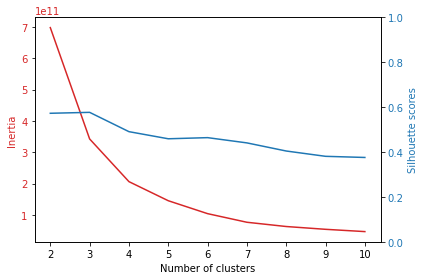

In [106]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [107]:
good_k = 2
km = KMeans(n_clusters=good_k, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)
y_km = km.fit_predict(dataset)
print("Silhouette:", silhouette_score(dataset, y_km))

Silhouette: 0.5727304299326389


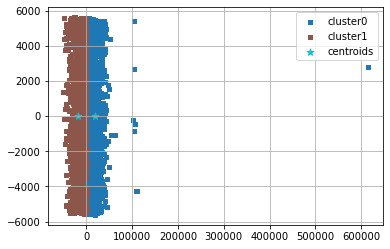

In [109]:
plot_clusters(dataset, y_km, dim=(0, 1), points = km.cluster_centers_)